/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/regdata/dataloaders/base.py:202: UserWarning: data not found. Downloading...
  warnings.warn('data not found. Downloading...')


(torch.Size([101, 1]), torch.Size([101, 1]))

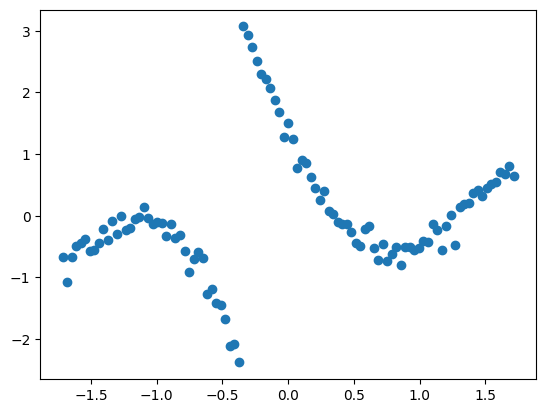

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import einsum, rearrange, reduce
from tqdm.notebook import tqdm
import regdata as rd
rd.set_backend('torch')

# n = 100
# x = torch.linspace(-1, 1, n).reshape(-1, 1)
# y = torch.sin(2 * 3.14 * x) + torch.randn_like(x) * 0.1
x, y, _ = rd.Jump1D().get_data()
x = x.float()
y = y.float().reshape(-1, 1)

idx = torch.argsort(x, dim=0).reshape(-1)
x = x[idx]
y = y[idx]

plt.plot(x, y, 'o');
x.shape, y.shape

In [46]:
class MOE(nn.Module):
    def __init__(self, x_dim, n_experts, n_levels):
        super(MOE, self).__init__()
        self.model = nn.ModuleList([nn.Linear(x_dim, n_experts) for _ in range(n_levels)])
        
    def forward(self, x):
        outs = [model(x) for model in self.model] # (n_levels, n_samples, n_experts)
        outs = torch.stack(outs, dim=0) # (n_levels, n_samples, n_experts)
        outs = outs.prod(dim=0) # (n_samples, n_experts)
        return outs.sum(dim=-1, keepdim=True) # (n_samples, 1) 

  0%|          | 0/1000 [00:00<?, ?it/s]

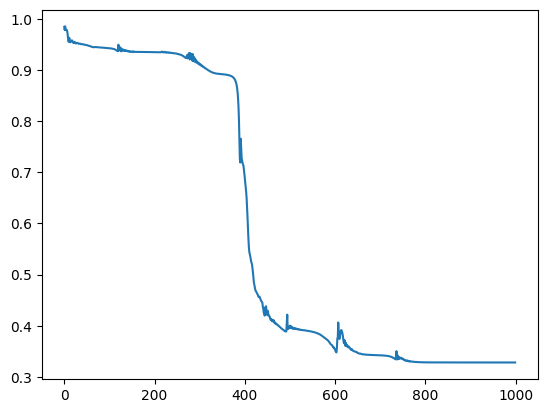

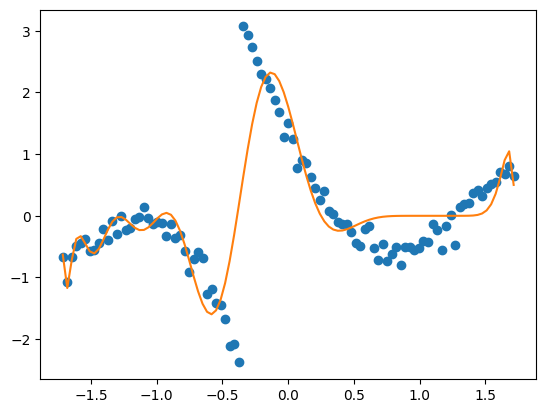

In [47]:
model = MOE(1, 2, 20)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

pbar = tqdm(range(1000))
model.train()
losses = []
for epoch in pbar:
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())
    
plt.plot(losses)
plt.show()
    
model.eval()
with torch.no_grad():
    y_pred = model(x)
plt.plot(x, y, 'o', label='true')
plt.plot(x, y_pred.numpy(), label='predicted')